In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

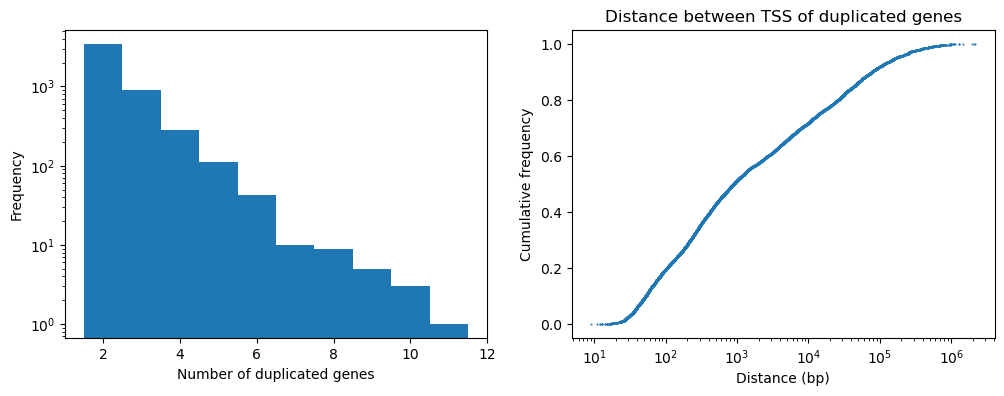

In [2]:
genome = 'mm10'
win_size_kb = 5

promoterome_infile = f"/home/jbreda/Promoterome/results/{genome}/promoterome_pm{win_size_kb}kb_filtered.bed"

Promoterome = pd.read_csv(promoterome_infile, sep='\t')
CHR = ['chr' + str(i) for i in range(1, 20)] + ['chrX', 'chrY']
STRAND = ['+', '-']
D = []
N = []
for chr in CHR:
    for strand in STRAND:
        # find duplicated genes names
        Promoterome_chr = Promoterome[(Promoterome['chr'] == chr) & (Promoterome['strand'] == strand)]
        duplicated_genes = Promoterome_chr[Promoterome_chr.duplicated(subset='gene', keep=False)]

        for g in duplicated_genes.gene.unique():
            idx = Promoterome_chr[Promoterome_chr['gene'] == g].index
            n = len(idx)
            N.append(n)

            for i in range(n-1):
                for j in range(i + 1, n):
                    d = np.abs( (Promoterome_chr.loc[idx[i], 'start'] + Promoterome_chr.loc[idx[i], 'end']) / 2 - (Promoterome_chr.loc[idx[j], 'start'] + Promoterome_chr.loc[idx[j], 'end']) / 2)
                    D.append(d)
D = np.sort(np.array(D))

fig, axes = plt.subplots(1,2,figsize=(12,4))

ax = axes[0]
ax.hist(N,bins=np.unique(N)-.5, rwidth=1)
ax.set_xlabel('Number of duplicated genes')
ax.set_ylabel('Frequency')
ax.set_yscale('log')

ax = axes[1]
ax.plot(D, np.arange(1,len(D)+1)/len(D), '.', markersize=1)
ax.set_xlabel('Distance (bp)')
ax.set_ylabel('Cumulative frequency')
ax.set_title('Distance between TSS of duplicated genes')
ax.set_xscale('log')

28807
24853


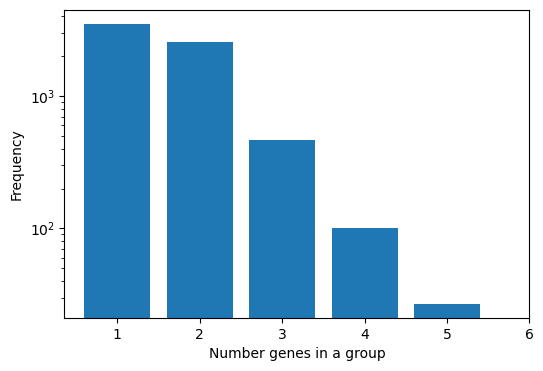

In [35]:
def find_subgroups(pos,idx, threshold):
    
    assert np.all(pos == sorted(pos)), "Points must be sorted"
    n = len(pos)

    # Initialize variables
    groups = []
    current_group = []
    
    # Iterate through the sorted points
    for i in range(n):
        if not current_group:
            # Start the first group with the first point
            current_group.append(idx[i])
        else:
            # Check if the current point can be added to the current group
            if pos[i] - pos[i-1] <= threshold:
                current_group.append(idx[i])
            else:
                # If not, finalize the current group and start a new one
                groups.append(current_group)
                current_group = [idx[i]]
    # Finally, add the last group
    if current_group:
        groups.append(current_group)

    return groups

genome = 'mm10'
win_size_kb = 5
promoterome_infile = f"/home/jbreda/Promoterome/results/{genome}/promoterome_pm{win_size_kb}kb_filtered.bed"
Promoterome = pd.read_csv(promoterome_infile, sep='\t')
CHR = ['chr' + str(i+1) for i in range(19)] + ['chrX', 'chrY']
STRAND = ['+', '-']
th = 1000

groups = []
for chr in CHR:
    for strand in STRAND:
        # find duplicated genes names in promoterome
        Promoterome_chr = Promoterome[(Promoterome['chr'] == chr) & (Promoterome['strand'] == strand)]
        duplicated_genes = Promoterome_chr[Promoterome_chr.duplicated(subset='gene', keep=False)]

        if np.any( duplicated_genes.loc[:,'start'].values[1:] - duplicated_genes.loc[:,'start'].values[:-1] <= 0 ):
            print('Warning: duplicated genes are not sorted by start position')
            print(chr,strand)
            break

        if chr == 'chr11':
            duplicated_genes = Promoterome[Promoterome.gene=='Stat5a']

        for g in duplicated_genes.gene.unique():
            # find duplicated genes indices
            idx = Promoterome_chr[Promoterome_chr['gene'] == g].index
            pos = np.sum(Promoterome_chr.loc[idx, ['start','end']].values,1) / 2

            groups.extend(find_subgroups(pos,idx,th))

L = [len(g) for g in groups]

fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.hist(L,bins=np.unique(L)-.5, rwidth=.8)
ax.set_xticks(np.unique(L))
ax.set_xlabel('Number genes in a group')
ax.set_ylabel('Frequency')
ax.set_yscale('log')

print(Promoterome.shape[0])

for group in groups:
    if len(group) > 1:
        Promoterome.loc[group,'gene'].values

        # merge all promoters in group to the 1st one
        start = int(np.round(Promoterome.loc[group,'start'].mean()))
        end = int(np.round(Promoterome.loc[group,'end'].mean()))
        id = '|'.join( Promoterome.loc[group,'id'].values )
        Promoterome.loc[group[0],'start'] = start
        Promoterome.loc[group[0],'end'] = end
        Promoterome.loc[group[0],'id'] = id
        # drop the other promoters
        Promoterome.drop(group[1:], inplace=True)

print(Promoterome.shape[0])

array([10000])